In [3]:
# Load dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import arviz as az
from scipy.stats import zscore
from scipy.special import expit
from pymc import do, observe

In [4]:
hems_d = pd.read_csv('/Users/JO/PhD/neurocritical-transfers/notes/final-analysis/5-modeling-weather-v-outcome/hems_d.csv', index_col=False)

In [5]:
d_point = hems_d.dropna(axis=0, subset='both_point_hems_minima').copy()
d_window = hems_d.dropna(axis=0, subset='both_hems_minima_window').copy()

data = d_point

n_samples = len(data)

SAMPLE = np.arange(n_samples)

HEMS_MINIMA, TREATMENT =  pd.factorize(data['both_point_hems_minima'], sort=True)

SENDING_CENTER_IDX, SENDING_CENTER =  pd.factorize(data['sir_icu_name'], sort=True)
RECEIVING_CENTER_IDX, RECEIVING_CENTER = pd.factorize(data['tertiary_center'], sort=True)

MONTH_IDX, MONTH = pd.factorize(data['utc_month'], sort=True)
DAY_IDX, DAY = pd.factorize(data['utc_day'], sort=True)
HOUR_IDX, HOUR = pd.factorize(data['admission_hour_utc'], sort=True)
DAYLIGHT_IDX, DAYLIGHT = pd.factorize(data['sending_daylight'], sort=True)
AFTERHOURS_IDX, AFTERHOURS = pd.factorize(data['icu_admission_afterhours'], sort=True)

DX_IDX, DX = pd.factorize(data['DX'], sort=True)

AGE_STD = zscore(data['age'])
FEMALE_IDX, FEMALE = pd.factorize(data['sex_female'], sort=True)

CONCIOUSNESS_IDX, CONCIOUSNESS = pd.factorize(data['sir_consciousness_level'], use_na_sentinel=True, sort=True)
CONCIOUSNESS_IDX = np.ma.masked_equal(CONCIOUSNESS_IDX, -1)

## Model defintions

### Linear model

In [6]:
COORDS = {'sample': SAMPLE, 'treatment': TREATMENT, 'sending_center': SENDING_CENTER, 'daylight': DAYLIGHT, 'afterhours': AFTERHOURS, 'month': MONTH, 'hour': HOUR, 'AGE_STD': AGE_STD, 'dx': DX, 'conciousness': CONCIOUSNESS}
with pm.Model(coords=COORDS) as linear_model:
    ## Input data variables
    # Treatment exposure
    x = pm.Bernoulli('X', p=.75, dims='sample')

    p_MONTH = pm.Dirichlet('p_M', a=np.ones(12))
    #p_DAY = pm.Dirichlet('p_DAY', a=np.ones(366))
    p_HOUR = pm.Dirichlet('p_H', a=np.ones(24))
    p_DAYLIGHT = pm.Beta('p_D', 2, 2)
    p_SENDING_CENTER = pm.Dirichlet('p_SC', a=np.ones(len(SENDING_CENTER)))
    p_DX = pm.Dirichlet('p_DX', a=np.ones(len(DX))/len(DX))
    p_CONCIOUSNESS = pm.Dirichlet('p_CONCIOUSNESS', a=np.ones(len(CONCIOUSNESS))/len(CONCIOUSNESS))


    month = pm.Categorical('MONTH', p=p_MONTH, dims='sample')
    #day = pm.Categorical('DAY', p=p_DAY, dims='sample')
    hour = pm.Categorical('HOUR', p=p_HOUR, dims='sample')
    daylight = pm.Bernoulli('DAYLIGHT', p=p_DAYLIGHT, dims='sample')
    afterhours = pm.Bernoulli('AFTERHOURS', p=.75, dims='sample')

    # Other variables
    age_std = pm.Normal('AGE_STD', 0, 1, dims='sample')
    dx = pm.Categorical('DX', p=p_DX, dims='sample')
    conciousness_imputed = pm.Categorical('CONCIOUSNESS', p=p_CONCIOUSNESS, dims='sample', observed=CONCIOUSNESS_IDX)
    center = pm.Categorical('CENTER', p=p_SENDING_CENTER, dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in CONCIOUSNESS contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [7]:
with linear_model: 
    # Intercept
    # Rationale the mu_bar_prior comes from that I expect the "baseline" mortality risk is approx 20%
    # The sigma bar prior essentially says that the between center differences are probably small, but that it is not 
    # impossible that variations could be large (moratlity risk x1.5-2 between centers)
    mu_bar_beta_0 = pm.Normal('mu_bar_beta_0', -1, .25)
    sigma_bar_beta_0 = pm.HalfNormal('sigma_bar_beta_0', .2)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='sending_center')
    beta_0 = pm.Deterministic('beta_0', mu_bar_beta_0 + z_beta_0 * sigma_bar_beta_0, dims='sending_center')

    # Treatment effect
    # I expect the treatment effect to be very small. Almost zero. The real impact of a high functionining
    # HEMS system might be 2-3% on the average patient. Here, we are actually testing the HEMS weather minima.
    # Therefore the effect must be diluted by a factor of 2-3 as most transfers will not be undertaken by such a system anyways.
    # While the effect is small, there can quite singificant variation between centers
    mu_bar_beta_x = pm.Normal('mu_bar_beta_x', 0, .1)
    sigma_bar_beta_x = pm.HalfNormal('sigma_bar_beta_x', .1)
    z_beta_x = pm.Normal('z_beta_x', 0, 1, dims='sending_center')
    beta_x = pm.Deterministic('beta_x', mu_bar_beta_x + z_beta_x * sigma_bar_beta_x, dims='sending_center')
    
    # Confounding effects of time
    # I expect the effect size to a few percent for most patients
    beta_month = pm.Normal('beta_month', 0, .15, dims='month')
   # beta_hour = pm.Normal('beta_hour', 0, .15, dims='hour')
    beta_afterhours = pm.Normal('beta_afterhours', 0, .3)
    
    # Non-confounders
    # I expect the effect of diagnosis to be larger than that of age. A change of 1 std dev age might have an effect of +/- 5-10% on mortality
    # The effect of dx is larger and the effect of concioussness even a bit larger
    beta_dx = pm.Normal('beta_dx', 0, 1, dims='dx')
    beta_age = pm.Normal('beta_age', 0.5, .75)
    beta_conciousness = pm.Normal('beta_conciousness', 0, .75, dims='conciousness')
    beta_daylight = pm.Normal('beta_daylight', 0, .1)

    # Outcome model
    p_i = pm.Deterministic('p_y', beta_0[center] + beta_x[center] * x + beta_daylight * daylight + beta_month[month] + beta_afterhours * afterhours + beta_dx[dx] + beta_conciousness[conciousness_imputed] + beta_age * age_std, dims='sample')
    y = pm.Bernoulli('Y', logit_p=p_i, dims='sample')

#### Priors
Understanding implications of prior choices is diffucult just looking at distributional assumptions. Here, we will plot implications of the priors on the outcome scale (probability of d30 mortality).

In [8]:
with linear_model:
    prior = pm.sample_prior_predictive(8)

Sampling: [AFTERHOURS, AGE_STD, CENTER, CONCIOUSNESS_observed, CONCIOUSNESS_unobserved, DAYLIGHT, DX, HOUR, MONTH, X, Y, beta_afterhours, beta_age, beta_conciousness, beta_daylight, beta_dx, beta_month, mu_bar_beta_0, mu_bar_beta_x, p_CONCIOUSNESS, p_D, p_DX, p_H, p_M, p_SC, sigma_bar_beta_0, sigma_bar_beta_x, z_beta_0, z_beta_x]


First, let's see the priors for variation in outcome between the sending centers. Substantial variation should be allowed.

(0.0, 1.0)

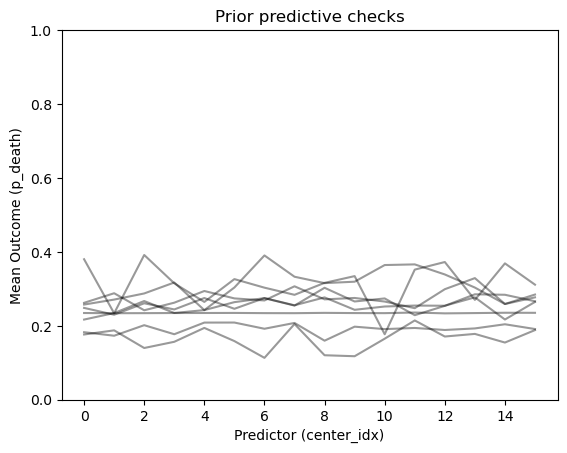

In [9]:
_, ax = plt.subplots()
import xarray as xr
x = xr.DataArray(np.linspace(0, 15, 16).astype(int), dims=["sending_center"],)
priors = prior.prior
y = expit(priors["beta_0"])

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (center_idx)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0,1)

Next, let's see the prior implications on differences in outcome between months.

(0.0, 1.0)

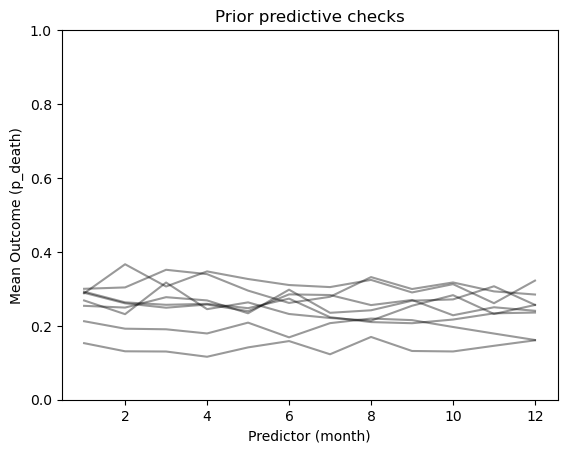

In [10]:
_, ax = plt.subplots()
import xarray as xr
x_month = xr.DataArray(np.linspace(1, 12, 12).astype(int), dims=["month"],)
y = expit(priors['mu_bar_beta_0'] + priors["beta_month"])

ax.plot(x_month, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (month)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0,1)

Now, the effect of concioussness levels on outcome.

(0.0, 1.0)

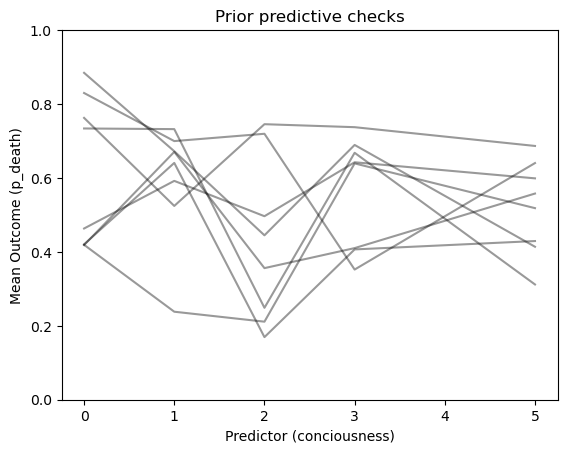

In [11]:
_, ax = plt.subplots()
import xarray as xr
x = xr.DataArray(np.linspace(0, 5, 5).astype(int), dims=["conciousness"],)
y = expit(priors["beta_conciousness"])

ax.plot(x, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (conciousness)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0,1)

Priors for treatment effects and the treatment effect variation between centers. To make the plot less busy, we only plot for the case where the "baseline" mortality risk is approximately 25%.

(0.0, 1.0)

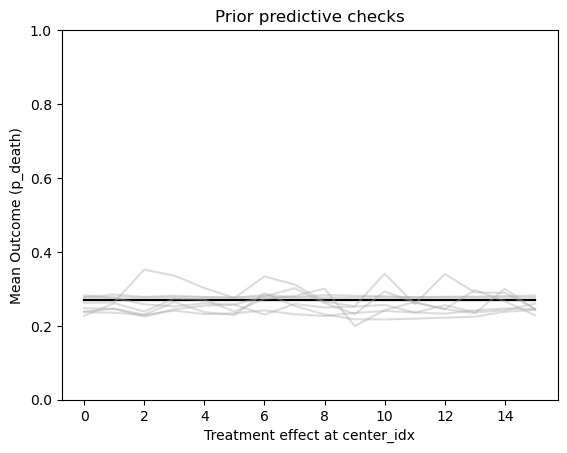

In [12]:
_, ax = plt.subplots()
import xarray as xr
x = xr.DataArray(np.linspace(0, 15, 16).astype(int), dims=["sending_center"],)
y0 = expit(-1 + 0*priors["beta_x"])
y1 = expit(-1 + 1*priors["beta_x"])

ax.plot(x, y0.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.plot(x, y1.stack(sample=("chain", "draw")), c="darkgrey", alpha=0.4)

ax.set_xlabel("Treatment effect at center_idx")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0,1)


Now, standardized age vs. outcome. Here with a baseline risk of a little under 20%.

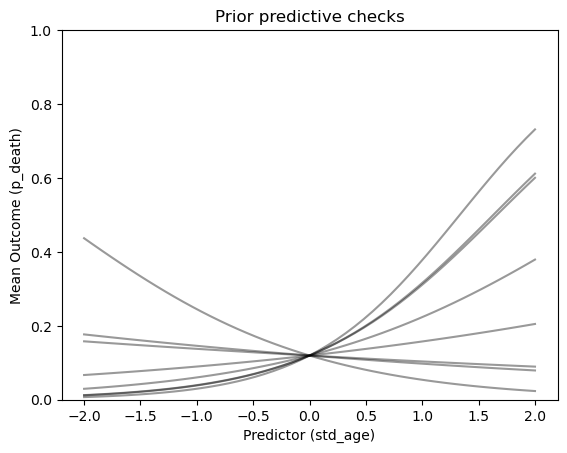

In [13]:
_, ax = plt.subplots()
import xarray as xr
x_std_age = xr.DataArray(np.linspace(-2, 2, 51), dims=["age"])
y = expit(-2 + priors["beta_age"] * x_std_age)

# Iterate over columns of y and plot each one against x_std_age
for i in range(y.shape[1]):
    ax.plot(x_std_age, y[:, i].squeeze(), c="k", alpha=0.4)

ax.set_xlabel("Predictor (std_age)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0, 1)
plt.show()

Priors for the effect of diagnosis on outcome.

(0.0, 1.0)

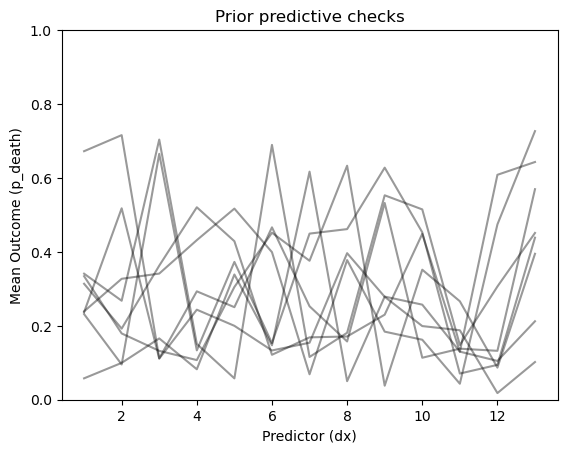

In [14]:
_, ax = plt.subplots()
import xarray as xr
x_dx = xr.DataArray(np.linspace(1, 13, 13).astype(int), dims=["dx"],)
y = expit(priors['mu_bar_beta_0'] + priors["beta_dx"])

ax.plot(x_dx, y.stack(sample=("chain", "draw")), c="k", alpha=0.4)
ax.set_xlabel("Predictor (dx)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0,1)

And here the effect of daylight on outcome. X axis should really be only 0, 1.

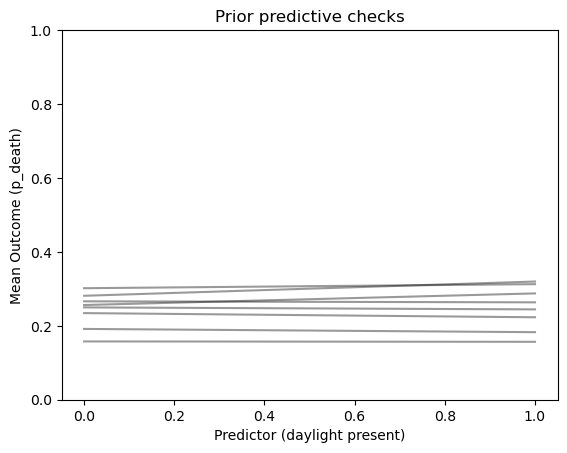

In [15]:
_, ax = plt.subplots()
import xarray as xr
x_daylight = xr.DataArray(np.linspace(0, 1, 2), dims=["daylight"])
y = expit(priors["mu_bar_beta_0"] + priors["beta_daylight"] * x_daylight)

# Iterate over columns of y and plot each one against x_std_age
for i in range(y.shape[1]):
    ax.plot(x_daylight, y[:, i].squeeze(), c="k", alpha=0.4)

ax.set_xlabel("Predictor (daylight present)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0, 1)
plt.show()

Afterhours effect:

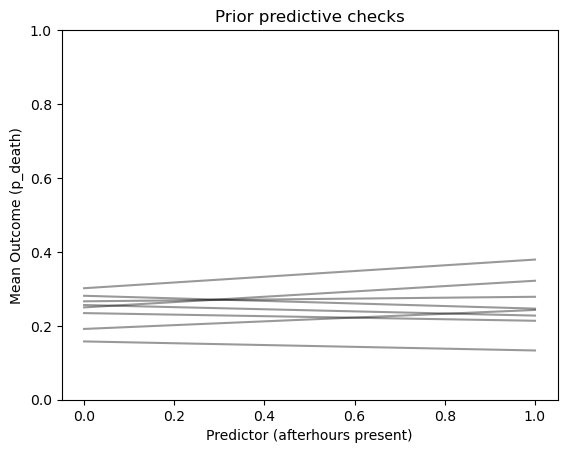

In [16]:
_, ax = plt.subplots()
import xarray as xr
x_afterhours = xr.DataArray(np.linspace(0, 1, 2), dims=["afterhours"])
y = expit(priors["mu_bar_beta_0"] + priors["beta_afterhours"] * x_afterhours)

# Iterate over columns of y and plot each one against x_std_age
for i in range(y.shape[1]):
    ax.plot(x_afterhours, y[:, i].squeeze(), c="k", alpha=0.4)

ax.set_xlabel("Predictor (afterhours present)")
ax.set_ylabel("Mean Outcome (p_death)")
ax.set_title("Prior predictive checks")
ax.set_ylim(0, 1)
plt.show()

#### Model fitting
All in all, most priors are conservative, but at least roughly represent my idea of the world. Next, let's fit the model.

In [17]:
observations={'X': HEMS_MINIMA, 'MONTH': MONTH_IDX, 'HOUR': HOUR_IDX, 'AFTERHOURS': AFTERHOURS_IDX, 'DAYLIGHT': DAYLIGHT_IDX, 'DX': DX_IDX, 'AGE_STD': AGE_STD, 'CENTER': SENDING_CENTER_IDX, 'Y': data.d30}

model_with_obs = observe(linear_model, observations)
with model_with_obs:
    idata_linear = pm.sample(idata_kwargs={'log_likelihood':True} )

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_M, p_H, p_D, p_SC, p_DX, p_CONCIOUSNESS, mu_bar_beta_0, sigma_bar_beta_0, z_beta_0, mu_bar_beta_x, sigma_bar_beta_x, z_beta_x, beta_month, beta_afterhours, beta_dx, beta_age, beta_conciousness, beta_daylight]
>CategoricalGibbsMetropolis: [CONCIOUSNESS_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


## Linear model with less conservative priors

In [18]:
COORDS = {'sample': SAMPLE, 'treatment': TREATMENT, 'sending_center': SENDING_CENTER, 'daylight': DAYLIGHT, 'afterhours': AFTERHOURS, 'month': MONTH, 'hour': HOUR, 'AGE_STD': AGE_STD, 'dx': DX, 'conciousness': CONCIOUSNESS}
with pm.Model(coords=COORDS) as linear_model_loose:
    ## Input data variables
    # Treatment exposure
    x = pm.Bernoulli('X', p=.75, dims='sample')

    p_MONTH = pm.Dirichlet('p_M', a=np.ones(12))
    #p_DAY = pm.Dirichlet('p_DAY', a=np.ones(366))
    p_HOUR = pm.Dirichlet('p_H', a=np.ones(24))
    p_DAYLIGHT = pm.Beta('p_D', 2, 2)
    p_SENDING_CENTER = pm.Dirichlet('p_SC', a=np.ones(len(SENDING_CENTER)))
    p_DX = pm.Dirichlet('p_DX', a=np.ones(len(DX))/len(DX))
    p_CONCIOUSNESS = pm.Dirichlet('p_CONCIOUSNESS', a=np.ones(len(CONCIOUSNESS))/len(CONCIOUSNESS))

    month = pm.Categorical('MONTH', p=p_MONTH, dims='sample')
    #day = pm.Categorical('DAY', p=p_DAY, dims='sample')
    hour = pm.Categorical('HOUR', p=p_HOUR, dims='sample')
    daylight = pm.Bernoulli('DAYLIGHT', p=p_DAYLIGHT, dims='sample')
    afterhours = pm.Bernoulli('AFTERHOURS', p=.75, dims='sample')

    # Other variables
    age_std = pm.Normal('AGE_STD', 0, 1, dims='sample')
    dx = pm.Categorical('DX', p=p_DX, dims='sample')
    conciousness_imputed = pm.Categorical('CONCIOUSNESS', p=p_CONCIOUSNESS, dims='sample', observed=CONCIOUSNESS_IDX)
    center = pm.Categorical('CENTER', p=p_SENDING_CENTER, dims='sample')

    # Intercept
    # Rationale the mu_bar_prior comes from that I expect the "baseline" mortality risk is approx 20%
    # The sigma bar prior essentially says that the between center differences are probably small, but that it is not 
    # impossible that variations could be large (moratlity risk x1.5-2 between centers)
    mu_bar_beta_0 = pm.Normal('mu_bar_beta_0', 0, 1)
    sigma_bar_beta_0 = pm.HalfNormal('sigma_bar_beta_0', 2)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='sending_center')
    beta_0 = pm.Deterministic('beta_0', mu_bar_beta_0 + z_beta_0 * sigma_bar_beta_0, dims='sending_center')

    # Treatment effect
    # I expect the treatment effect to be very small. Almost zero. The real impact of a high functionining
    # HEMS system might be 2-3% on the average patient. Here, we are actually testing the HEMS weather minima.
    # Therefore the effect must be diluted by a factor of 2-3 as most transfers will not be undertaken by such a system anyways.
    # While the effect is small, there can quite singificant variation between centers
    mu_bar_beta_x = pm.Normal('mu_bar_beta_x', 0, 1)
    sigma_bar_beta_x = pm.HalfNormal('sigma_bar_beta_x', 2)
    z_beta_x = pm.Normal('z_beta_x', 0, 1, dims='sending_center')
    beta_x = pm.Deterministic('beta_x', mu_bar_beta_x + z_beta_x * sigma_bar_beta_x, dims='sending_center')
    
    # Confounding effects of time
    # I expect the effect size to a few percent for most patients
    beta_month = pm.Normal('beta_month', 0, 1, dims='month')
    beta_afterhours = pm.Normal('beta_afterhours', 0, 1)
    
    # Non-confounders
    # I expect the effect of diagnosis to be larger than that of age. A change of 1 std dev age might have an effect of +/- 5-10% on mortality
    # The effect of dx is larger and the effect of concioussness even a bit larger
    beta_dx = pm.Normal('beta_dx', 0, 1, dims='dx')
    beta_age = pm.Normal('beta_age', 0.5, 2)
    beta_conciousness = pm.Normal('beta_conciousness', 0, 2, dims='conciousness')
    beta_daylight = pm.Normal('beta_daylight', 0, 1)

    # Outcome model
    p_i = pm.Deterministic('p_y', beta_0[center] + beta_x[center] * x + beta_daylight * daylight + beta_month[month] + beta_afterhours * afterhours + beta_dx[dx] + beta_conciousness[conciousness_imputed] + beta_age * age_std, dims='sample')
    y = pm.Bernoulli('Y', logit_p=p_i, dims='sample')

observations={'X': HEMS_MINIMA, 'MONTH': MONTH_IDX, 'HOUR': HOUR_IDX, 'AFTERHOURS': AFTERHOURS_IDX, 'DAYLIGHT': DAYLIGHT_IDX, 'DX': DX_IDX, 'AGE_STD': AGE_STD, 'CENTER': SENDING_CENTER_IDX, 'Y': data.d30}

model_with_obs = observe(linear_model, observations)
with model_with_obs:
    idata_linear_loose = pm.sample(idata_kwargs={'log_likelihood':True} )

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in CONCIOUSNESS contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_M, p_H, p_D, p_SC, p_DX, p_CONCIOUSNESS, mu_bar_beta_0, sigma_bar_beta_0, z_beta_0, mu_bar_beta_x, sigma_bar_beta_x, z_beta_x, beta_month, beta_afterhours, beta_dx, beta_age, beta_conciousness, beta_daylight]
>CategoricalGibbsMetropolis: [CONCIOUSNESS_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 88 seconds.


## FBLI model
Here a full luxury bayesian inference models with linear dependencies will be defined. Priors the same as in the linear regression, but with less conservative priors for the effect of month and daylight on HEMS minima.

In [19]:
COORDS = {'sample': SAMPLE, 'treatment': TREATMENT, 'sending_center': SENDING_CENTER, 'daylight': DAYLIGHT, 'afterhours': AFTERHOURS, 'day': DAY, 'month': MONTH, 'hour': HOUR, 'AGE_STD': AGE_STD, 'dx': DX, 'conciousness': CONCIOUSNESS}
with pm.Model(coords=COORDS) as FLBI:
    ## Input data variables

    p_MONTH = pm.Dirichlet('p_M', a=np.ones(12))
    p_DAY = pm.Dirichlet('p_DAY', a=np.ones(366))
    p_HOUR = pm.Dirichlet('p_H', a=np.ones(24))
    p_DAYLIGHT = pm.Beta('p_D', 2, 2)
    p_SENDING_CENTER = pm.Dirichlet('p_SC', a=np.ones(len(SENDING_CENTER)))
    p_DX = pm.Dirichlet('p_DX', a=np.ones(len(DX))/len(DX))
    p_CONCIOUSNESS = pm.Dirichlet('p_CONCIOUSNESS', a=np.ones(len(CONCIOUSNESS))/len(CONCIOUSNESS))


    month = pm.Categorical('MONTH', p=p_MONTH, dims='sample')
    day = pm.Categorical('DAY', p=p_DAY, dims='sample')
    hour = pm.Categorical('HOUR', p=p_HOUR, dims='sample')
    daylight = pm.Bernoulli('DAYLIGHT', p=p_DAYLIGHT, dims='sample')
    afterhours = pm.Bernoulli('AFTERHOURS', p=.75, dims='sample')
    # Other variables
    age_std = pm.Normal('AGE_STD', 0, 1, dims='sample')
    dx = pm.Categorical('DX', p=p_DX, dims='sample')
    conciousness_imputed = pm.Categorical('CONCIOUSNESS', p=p_CONCIOUSNESS, dims='sample', observed=CONCIOUSNESS_IDX)
    center = pm.Categorical('CENTER', p=p_SENDING_CENTER, dims='sample')

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/model/core.py:1317: ImputationWarning: Data in CONCIOUSNESS contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


In [20]:
with FLBI: 
    # Treatment assignment model
    # Month. hour and daylight causes X
    beta_x_0 = pm.Normal('beta_x_0', 0, 2)
    beta_x_month = pm.Normal('beta_x_month', 0, .5, dims='month')
    beta_x_hour = pm.Normal('beta_x_hour', 0, .5, dims='hour')
    beta_x_daylight = pm.Normal('beta_x_daylight', 1, 2)
    p_x = pm.Deterministic('p_x', pm.math.invlogit(beta_x_0 + beta_x_month[month] + beta_x_hour[hour] + beta_x_daylight * daylight))
    x = pm.Bernoulli('X', p=p_x, dims='sample')

    # Outcome model
    # Intercept
    # Rationale the mu_bar_prior comes from that I expect the "baseline" mortality risk is approx 20%
    # The sigma bar prior essentially says that the between center differences are probably small, but that it is not 
    # impossible that variations could be large (moratlity risk x1.5-2 between centers)
    mu_bar_beta_0 = pm.Normal('mu_bar_beta_0', -1, .1)
    sigma_bar_beta_0 = pm.HalfNormal('sigma_bar_beta_0', .1)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='sending_center')
    beta_0 = pm.Deterministic('beta_0', mu_bar_beta_0 + z_beta_0 * sigma_bar_beta_0, dims='sending_center')

    # Treatment effect
    # I expect the treatment effect to be very small. Almost zero. The real impact of a high functionining
    # HEMS system might be 2-3% on the average patient. Here, we are actually testing the HEMS weather minima.
    # Therefore the effect must be diluted by a factor of 2-3 as most transfers will not be undertaken by such a system anyways.
    # While the effect is small, there can quite singificant variation between centers
    mu_bar_beta_x = pm.Normal('mu_bar_beta_x', 0, .1)
    sigma_bar_beta_x = pm.HalfNormal('sigma_bar_beta_x', .1)
    z_beta_x = pm.Normal('z_beta_x', 0, 1, dims='sending_center')
    beta_x = pm.Deterministic('beta_x', mu_bar_beta_x + z_beta_x * sigma_bar_beta_x, dims='sending_center')
    
    # Confounding effects of time
    beta_month = pm.Normal('beta_month', 0, .15, dims='month')
    #beta_hour = pm.Normal('beta_hour', 0, .15, dims='hour')
    beta_afterhours = pm.Normal('beta_afterhours', 0, .3)
    
    # Non-confounders
    beta_dx = pm.Normal('beta_dx', 0, 1, dims='dx')
    beta_age = pm.Normal('beta_age', 0.5, .75)
    beta_conciousness = pm.Normal('beta_conciousness', 0, .75, dims='conciousness')

    # Outcome model
    p_i = pm.Deterministic('p_y', beta_0[center] + beta_x[center] * x + beta_month[month] + beta_afterhours * afterhours + beta_dx[dx] + beta_conciousness[conciousness_imputed] + beta_age * age_std, dims='sample')
    y = pm.Bernoulli('Y', logit_p=p_i, dims='sample')

In [21]:
observations={'X': HEMS_MINIMA, 'MONTH': MONTH_IDX, 'HOUR': HOUR_IDX, 'AFTERHOURS': AFTERHOURS_IDX, 'DAY': DAY_IDX, 'DAYLIGHT': DAYLIGHT_IDX, 'DX': DX_IDX, 'AGE_STD': AGE_STD, 'CENTER': SENDING_CENTER_IDX, 'Y': data.d30}
flbi_model_with_obs = observe(FLBI, observations)
with flbi_model_with_obs:
    idata_flbi = pm.sample(idata_kwargs={'log_likelihood':True}, target_accept=.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p_M, p_DAY, p_H, p_D, p_SC, p_DX, p_CONCIOUSNESS, beta_x_0, beta_x_month, beta_x_hour, beta_x_daylight, mu_bar_beta_0, sigma_bar_beta_0, z_beta_0, mu_bar_beta_x, sigma_bar_beta_x, z_beta_x, beta_month, beta_afterhours, beta_dx, beta_age, beta_conciousness]
>CategoricalGibbsMetropolis: [CONCIOUSNESS_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 329 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


## HSGP

Finally, a full luxury bayesian inference model with GP priors for the effect of time on outcome and treatment in order to allow for potentially better modeling of these effects. This model samples slow when including proper missing data handling.

In [22]:
n_samples = len(data)

SAMPLE = np.arange(n_samples)

HEMS_MINIMA, TREATMENT =  pd.factorize(data['both_point_hems_minima'], sort=True)

SENDING_CENTER_IDX, SENDING_CENTER =  pd.factorize(data['sir_icu_name'], sort=True)
RECEIVING_CENTER_IDX, RECEIVING_CENTER = pd.factorize(data['tertiary_center'], sort=True)

MONTH_IDX, MONTH = pd.factorize(data['utc_month'], sort=True)
DAY_IDX, DAY = pd.factorize(data['utc_day'], sort=True)
HOUR_IDX, HOUR = pd.factorize(data['utc_hour'], sort=True)
DAYLIGHT_IDX, DAYLIGHT = pd.factorize(data['sending_daylight'], sort=True)

DX_IDX, DX = pd.factorize(data['DX'], sort=True)

AGE_STD = zscore(data['age'])
FEMALE_IDX, FEMALE = pd.factorize(data['sex_female'], sort=True)

CONCIOUSNESS_IDX, CONCIOUSNESS = pd.factorize(data['sir_consciousness_level'], use_na_sentinel=False, sort=True)
#CONCIOUSNESS_IDX = np.ma.masked_equal(CONCIOUSNESS_IDX, -1)

In [85]:
COORDS = {'sample': SAMPLE, 'treatment': TREATMENT, 'sending_center': SENDING_CENTER, 'daylight': DAYLIGHT, 'day': DAY, 'month': MONTH, 'hour': HOUR, 'AGE_STD': AGE_STD, 'dx': DX, 'conciousness': CONCIOUSNESS}
with pm.Model(coords=COORDS) as hsgp:
    ## Input data variables
    # Treatment exposure
    p_MONTH = pm.Dirichlet('p_M', a=np.ones(12))
    p_DAY = pm.Dirichlet('p_DAY', a=np.ones(366))
    p_HOUR = pm.Dirichlet('p_H', a=np.ones(24))
    p_DAYLIGHT = pm.Beta('p_D', 2, 2)
    p_SENDING_CENTER = pm.Dirichlet('p_SC', a=np.ones(len(SENDING_CENTER)))
    p_DX = pm.Dirichlet('p_DX', a=np.ones(len(DX))/len(DX))
    p_CONCIOUSNESS = pm.Dirichlet('p_CONCIOUSNESS', a=np.ones(len(CONCIOUSNESS))/len(CONCIOUSNESS))

    month = pm.Categorical('MONTH', p=p_MONTH, dims='sample')
    day = pm.Categorical('DAY', p=p_DAY, dims='sample')
    hour = pm.Categorical('HOUR', p=p_HOUR, dims='sample')
    daylight = pm.Bernoulli('DAYLIGHT', p=p_DAYLIGHT, dims='sample')
    afterhours = pm.Bernoulli('AFTERHOURS', p=.75, dims='sample')

    # Other variables
    age_std = pm.Normal('AGE_STD', 0, 1, dims='sample')
    dx = pm.Categorical('DX', p=p_DX, dims='sample')
    conciousness_imputed = pm.Categorical('CONCIOUSNESS', p=p_CONCIOUSNESS, dims='sample', observed=CONCIOUSNESS_IDX)
    center = pm.Categorical('CENTER', p=p_SENDING_CENTER, dims='sample')

In [86]:
with hsgp:
    # treatment assignemnt
    # Month. hour and daylight causes X
    beta_x_0 = pm.Normal('beta_x_0', 0, 2)

    ls_x_MONTH = pm.Gamma('ls_x_MONTH', 2, 2)
    eta_x_MONTH = pm.HalfNormal('eta_x_MONTH', 1)
    cov_x_MONTH = pm.gp.cov.Periodic(1, ls=ls_x_MONTH, period=12)
    gp_x_MONTH = pm.gp.HSGPPeriodic(m=20, cov_func=cov_x_MONTH, scale=eta_x_MONTH**2)
    f_x_MONTH = gp_x_MONTH.prior('f_x_MONTH', X=month[:,None])
    
    ls_x_HOUR = pm.Gamma('ls_x_HOUR', 2, 2)
    eta_x_HOUR = pm.HalfNormal('eta_x_HOUR', 1)
    cov_x_HOUR = pm.gp.cov.Periodic(1, ls=ls_x_HOUR, period=24)
    gp_x_HOUR = pm.gp.HSGPPeriodic(m=20, cov_func=cov_x_HOUR, scale=eta_x_HOUR**2)
    f_x_HOUR = gp_x_HOUR.prior('f_x_HOUR', X=hour[:,None])

    beta_x_daylight = pm.Normal('beta_x_daylight', 1, 2)
    p_x = pm.Deterministic('p_x', pm.math.invlogit(beta_x_0 + f_x_MONTH + f_x_HOUR + beta_x_daylight * daylight))
    x = pm.Bernoulli('X', p=p_x, dims='sample')

    # Intercept
    # Rationale the mu_bar_prior comes from that I expect the "baseline" mortality risk is approx 20%
    # The sigma bar prior essentially says that the between center differences are probably small, but that it is not 
    # impossible that variations could be large (moratlity risk x1.5-2 between centers)
    mu_bar_beta_0 = pm.Normal('mu_bar_beta_0', -1, .25)
    sigma_bar_beta_0 = pm.HalfNormal('sigma_bar_beta_0', .2)
    z_beta_0 = pm.Normal('z_beta_0', 0, 1, dims='sending_center')
    beta_0 = pm.Deterministic('beta_0', mu_bar_beta_0 + z_beta_0 * sigma_bar_beta_0, dims='sending_center')

    # Treatment effect
    # I expect the treatment effect to be very small. Almost zero. The real impact of a high functionining
    # HEMS system might be 2-3% on the average patient. Here, we are actually testing the HEMS weather minima.
    # Therefore the effect must be diluted by a factor of 2-3 as most transfers will not be undertaken by such a system anyways.
    # While the effect is small, there can quite singificant variation between centers
    mu_bar_beta_x = pm.Normal('mu_bar_beta_x', 0, .1)
    sigma_bar_beta_x = pm.HalfNormal('sigma_bar_beta_x', .1)
    z_beta_x = pm.Normal('z_beta_x', 0, 1, dims='sending_center')
    beta_x = pm.Deterministic('beta_x', mu_bar_beta_x + z_beta_x * sigma_bar_beta_x, dims='sending_center')
    
    # Confounding effects of time
    ls_MONTH = pm.Gamma('ls_MONTH', 2, 2)
    eta_MONTH = pm.HalfNormal('eta_MONTH', 1)
    cov_MONTH = pm.gp.cov.Periodic(1, ls=ls_MONTH, period=12)
    gp_MONTH = pm.gp.HSGPPeriodic(m=20, cov_func=cov_MONTH, scale=eta_MONTH**2)
    f_MONTH = gp_MONTH.prior('f_MONTH', X=month[:,None])
    
    ls_HOUR = pm.Gamma('ls_HOUR', 2, 2)
    eta_HOUR = pm.HalfNormal('eta_HOUR', 1)
    cov_HOUR = pm.gp.cov.Periodic(1, ls=ls_HOUR, period=24)
    gp_HOUR = pm.gp.HSGPPeriodic(m=20, cov_func=cov_HOUR, scale=eta_HOUR**2)
    f_HOUR = gp_HOUR.prior('f_HOUR', X=hour[:,None])
    
    # Non-confounders
    # I expect the effect of diagnosis to be larger than that of age. A change of 1 std dev age might have an effect of +/- 5-10% on mortality
    # The effect of dx is larger and the effect of concioussness even a bit larger
    beta_dx = pm.Normal('beta_dx', 0, 1, dims='dx')
    beta_age = pm.Normal('beta_age', 0.5, .75)
    beta_conciousness = pm.Normal('beta_conciousness', 0, .75, dims='conciousness')
    beta_daylight = pm.Normal('beta_daylight', 0, .1)

    # Outcome model
    p_i = pm.Deterministic('p_y', pm.math.invlogit(beta_0[center] + beta_x[center] * x + beta_daylight * daylight + f_MONTH + f_HOUR + beta_dx[dx] + beta_conciousness[conciousness_imputed] + beta_age * age_std), dims='sample')
    y = pm.Bernoulli('Y', p=p_i, dims='sample')

In [87]:
observations={'X': HEMS_MINIMA, 'MONTH': MONTH_IDX, 'HOUR': HOUR_IDX, 'AFTERHOURS': AFTERHOURS_IDX, 'DAY': DAY_IDX, 'DAYLIGHT': DAYLIGHT_IDX, 'DX': DX_IDX, 'AGE_STD': AGE_STD, 'CENTER': SENDING_CENTER_IDX, 'Y': data.d30}
#observations={'X': HEMS_MINIMA, 'MONTH': MONTH_IDX, 'HOUR': HOUR_IDX, 'AFTERHOURS': AFTERHOURS_IDX, 'DAYLIGHT': DAYLIGHT_IDX, 'DX': DX_IDX, 'AGE_STD': AGE_STD, 'CENTER': SENDING_CENTER_IDX, 'Y': data.d30}
hspg_model_with_obs = observe(hsgp, observations)
with hspg_model_with_obs:
    idata_hsgp = pm.sample(nuts_sampler='nutpie', idata_kwargs={'log_likelihood':True}, target_accept=.9)

/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pymc/sampling/mcmc.py:292: UserWarning: `idata_kwargs` are currently ignored by the nutpie sampler
  warnings.warn(
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op iv does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/JO/miniforge3/envs/epidemiology-pyenv/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/Users/JO/miniforge3/envs/epidemiology-pyen

Let's plot posteriors for some of the coefficients. As we will see, there are no real differences between models. Also 

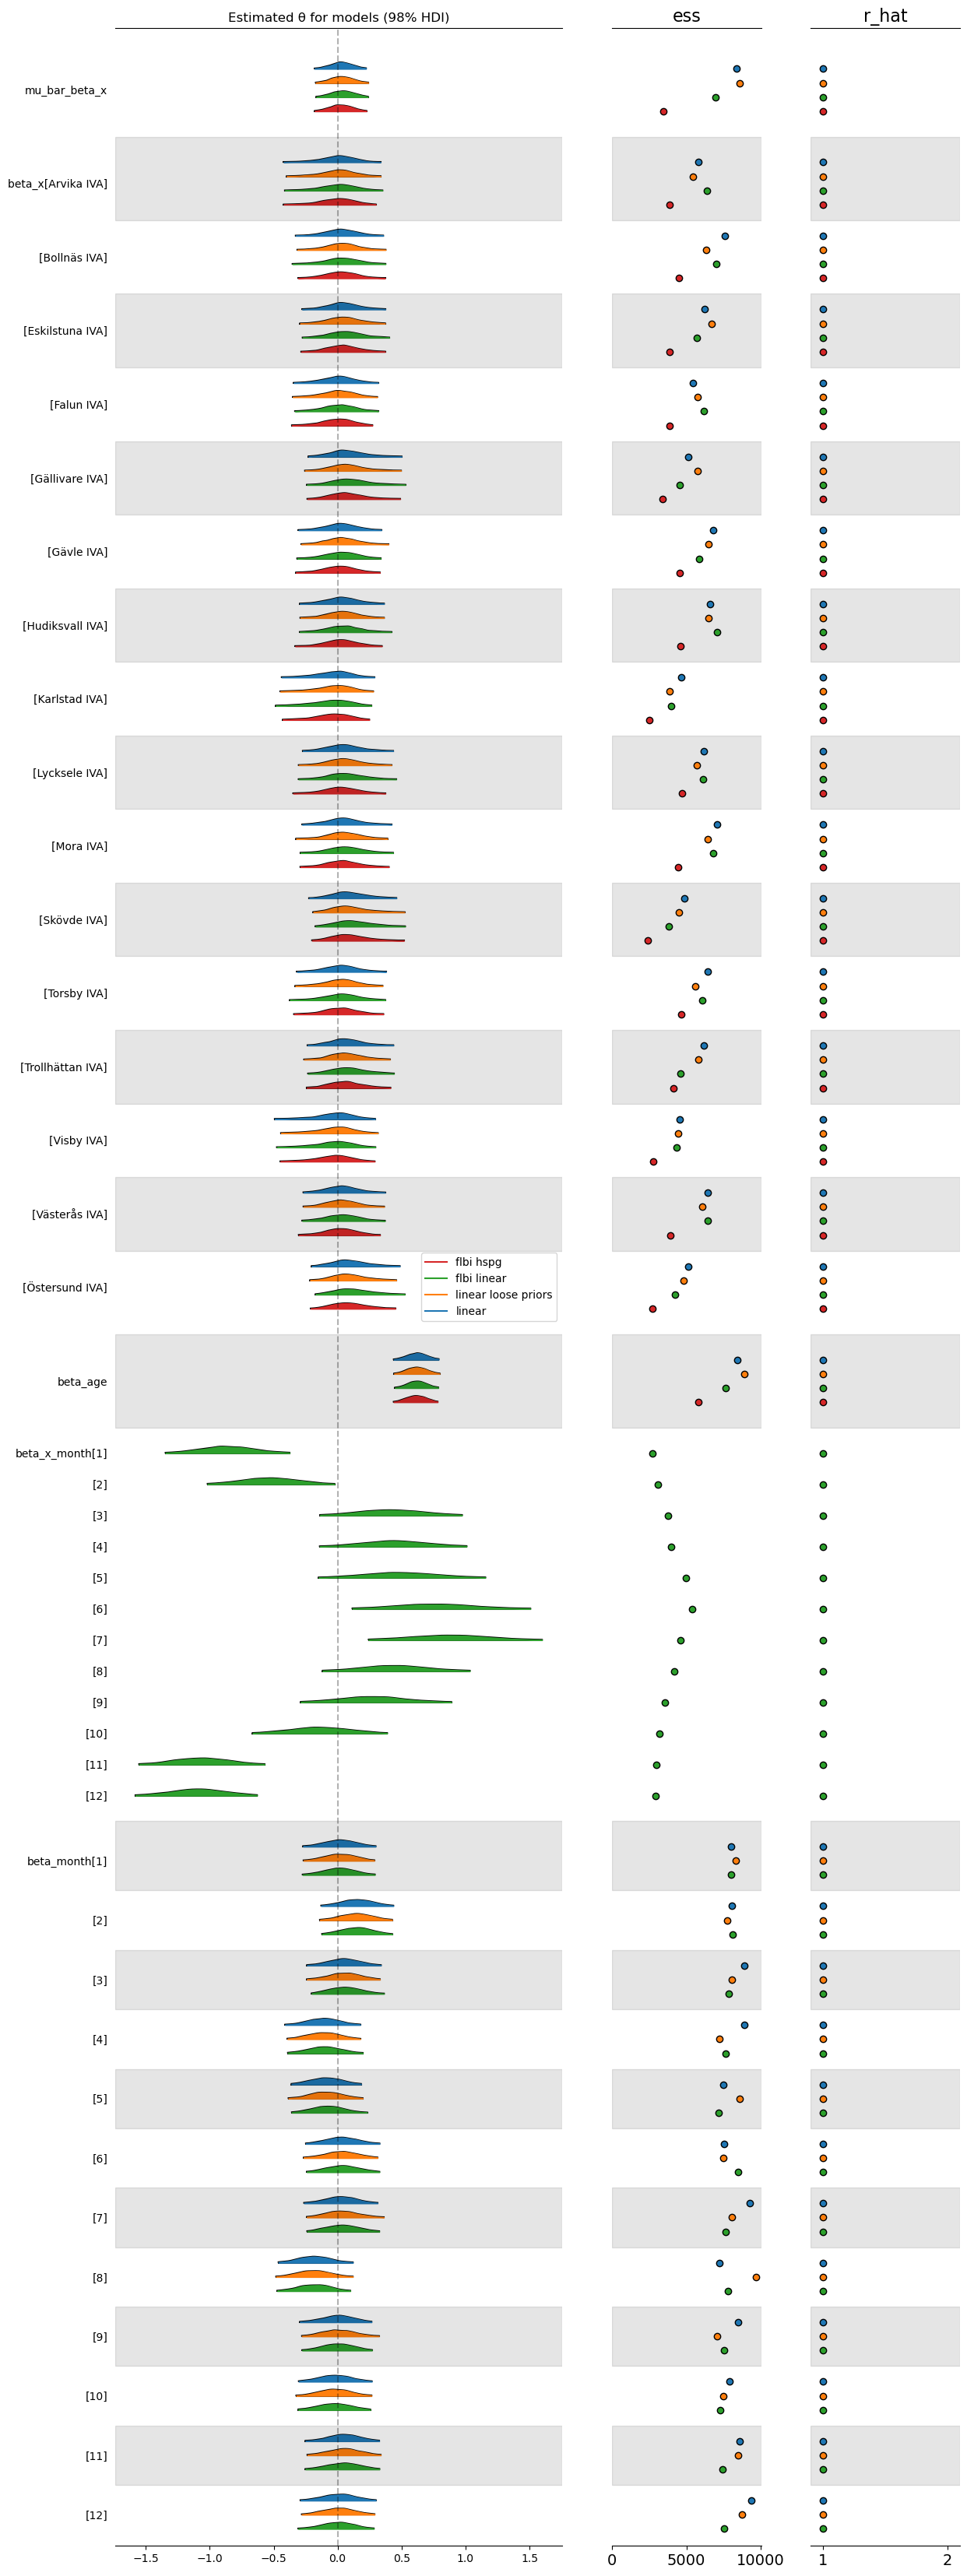

In [93]:
axes = az.plot_forest(
    [idata_linear, idata_linear_loose, idata_flbi,idata_hsgp],
    model_names=['linear', 'linear loose priors', 'flbi linear', 'flbi hspg'],
    kind='ridgeplot', ess=True,
    r_hat=True,
    ridgeplot_overlap=0.7,
    hdi_prob=0.98,
    combined=True,
    var_names=['mu_bar_beta_x', 'beta_x', 'beta_age', 'beta_x_month', 'beta_month'])
axes[0].set_title('Estimated θ for models (98% HDI)')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.3);

## Counterfactial estimation
Let's estimate the treatment effect in the HSGP model for example. It should be close to 0.

In [110]:
CONCIOUSNESS_IDX, CONCIOUSNESS = pd.factorize(data['sir_consciousness_level'], use_na_sentinel=False, sort=True)

cf_observations={'MONTH': MONTH_IDX, 'HOUR': HOUR_IDX, 'CONCIOUSNESS': CONCIOUSNESS_IDX, 'AGE_STD': AGE_STD, 'AFTERHOURS': AFTERHOURS_IDX, 'DAY': DAY_IDX, 'DAYLIGHT': DAYLIGHT_IDX, 'DX': DX_IDX, 'CENTER': SENDING_CENTER_IDX}
SEED = 42
hsgp_counterfactual = do(hsgp, cf_observations)
hsgp_do0 = do(hsgp_counterfactual, {'X': np.zeros(n_samples, dtype='int32')})
hsgp_do1 = do(hsgp_counterfactual, {'X': np.ones(n_samples, dtype='int32')})

In [116]:
do0_idata = pm.sample_posterior_predictive(
        idata_hsgp,
        hsgp_do0,
        var_names=['p_y', 'Y', 'X', 'AFTERHOURS', 'CONCIOUSNESS'],
        predictions=True,
        random_seed=SEED,
        )
do1_idata = pm.sample_posterior_predictive(
        idata_hsgp,
        hsgp_do1,
        var_names=['p_y','Y', 'X', 'AFTERHOURS', 'CONCIOUSNESS'],
        predictions=True,
        random_seed=SEED,
        )

Sampling: [Y]


Sampling: [Y]


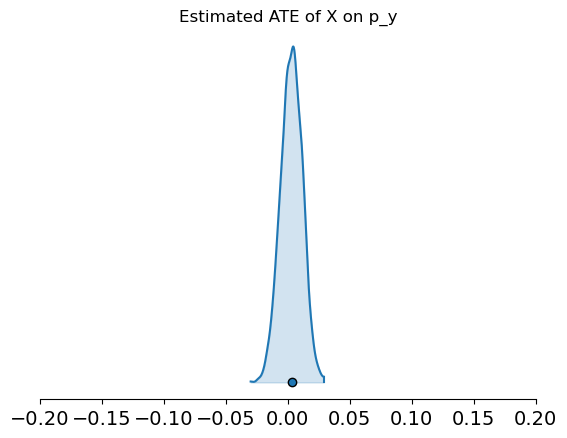

In [118]:
ate = (do1_idata.predictions.p_y - do0_idata.predictions.p_y).mean(dim='sample').values
az.plot_density(
    data=ate,
    hdi_prob=1,
    shade=0.2,
    point_estimate='median'
)
plt.xlim(-.2, .2)
plt.title('Estimated ATE of X on p_y');

I.e. no effect of HEMS minima being met on 30 day mortality.

## Conclusion
HEMS minima being met does not seem to have an impact on 30-day mortality.

This seems reasonable. My prior belief that a high performing CCT-system will have an absolute mortality benefit of <5% on a population with very high short term mortality risk. (I'm imagining 100 transfers of very sick ICU patients with acute MOF, hemorrhagic chock, critical neuro-ICU conditions, with a 30-40% ICU mortality risk. I can imagine in transit disasters being avoided by the high performing system in maybe 2-3 of these cases. Add to this some nebolous benefit in the slightly longer term.) The mortality benefit in a population with much lower mortality such as here (18%) must be lower. Maybe 2%. Probably lower.

But imagine that it is 2%. Imagine now a set of identical patients exposed to different HEMS minima conditions. In the HEMS minima = 0, group, the mortality will stay at the baseline 18%. In the HEMS minima = 1 group, I suspect that way less than half will be transported by HEMS, further diluting the potential benefit. Also, some patients in the HEMS minima = 0 group will probably be transported by HEMS at a later point than the 2 hour time window I have set up.

Finally, it could be that CCT systems have zero impact on mortality.

### Bonus: a small sanity check
Here I will use the frequentist library statsmodels to do a logistic regression with hems minima as a predictor together with confounders. Instead of hour of day I've used daylight and "afterhours" to account for diurnal variation. HEMS minima is n.s.

In [143]:
import statsmodels.formula.api as smf
data['age_std'] = AGE_STD
data['month_factor'] = data.icu_admission_month.astype(str)
log_reg = smf.logit("d30 ~ both_point_hems_minima + age_std + sir_consciousness_level + month_factor + icu_admission_afterhours + sending_daylight", data=data).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.329679
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    d30   No. Observations:                 2798
Model:                          Logit   Df Residuals:                     2778
Method:                           MLE   Df Model:                           19
Date:                Tue, 07 May 2024   Pseudo R-squ.:                  0.1516
Time:                        09:54:37   Log-Likelihood:                -922.44
converged:                       True   LL-Null:                       -1087.3
Covariance Type:            nonrobust   LLR p-value:                 1.580e-58
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -3.4726      0.292    -11.873      0.000      -4.046      -2.899
both_point_hems_minima[T.True]               0.1308      0.196      0.668      0.504      -0.253       0.514
sir_consciousness_level[T.II (GCS 7-12)]     1.2394      0.158      7.865      0.000       0.931       1.548
sir_consciousness_level[T.III (GCS 6)]       1.8329      0.213      8.601      0.000       1.415       2.251
sir_consciousness_level[T.IV (GCS 5)]        2.0666      0.237      8.707      0.000       1.601       2.532
sir_consciousness_level[T.V (GCS ≤4)]        2.5214      0.188     13.421      0.000       2.153       2.890
month_factor[T.10]                          -0.2389      0.291     -0.821      0.412      -0.809       0.332
month_factor[T.11]                           0.0438      0.279      0.157      0.875      -0.502       0.590
month_factor[T.12]                          -0.0501      0.289     -0.174      0.862      -0.616       0.515
month_factor[T.2]                            0.1954      0.269      0.725      0.468      -0.333       0.723
month_factor[T.3]                           -0.0390      0.277     -0.141      0.888      -0.582       0.504
month_factor[T.4]                           -0.6795      0.310     -2.193      0.028      -1.287      -0.072
month_factor[T.5]                           -0.5691      0.299     -1.902      0.057      -1.156       0.017
month_factor[T.6]                           -0.2996      0.292     -1.025      0.306      -0.873       0.274
month_factor[T.7]                           -0.3327      0.291     -1.144      0.253      -0.903       0.237
month_factor[T.8]                           -0.9261      0.319     -2.905      0.004      -1.551      -0.301
month_factor[T.9]                           -0.1968      0.285     -0.691      0.490      -0.756       0.362
sending_daylight[T.True]                     0.5299      0.164      3.230      0.001       0.208       0.851
age_std                                      0.6197      0.073      8.537      0.000       0.477       0.762
icu_admission_afterhours                     0.2270      0.153      1.486      0.137      -0.072       0.526
============================================================================================================
"""